## Binary Classification with XGBoost

In [1]:
# load packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, precision_score, f1_score
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

In [2]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
# load lagged dataset
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [9]:
# get desired df size
start_date = '2022-01-01'
end_date = '2022-12-31'
df = df.loc[start_date:end_date]

In [29]:
# impute, scale pipeline and smote (for class imbalance)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# define features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [32]:
# importance of the last redispatch status for the training data
def last_redispatch(y_train, X_test):
    """
    Computes the importance of the last redispatch status for each data point in the training data
    using a rolling window approach. It creates a list by summing the redispatch statuses of the
    last values within the defined window.

    For the test data, it calculates the importance of the last status by forward-filling the last
    computed importance values from the training set and exponentially decreasing values over the
    length of the test set.
    """
    window_size = 4  #last 60 min
    last_redispatch_importance_train = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum() # also incorporate the level ???
        last_redispatch_importance_train.append(importance)
    # forward fill the last value of 'last_redispatch_importance' for the test data with exponentially decreasing values
    decay_factor = 0.9
    last_redispatch_importance_test = [last_redispatch_importance_train[-1] * (decay_factor ** i) for i in range(len(X_test))]

    return last_redispatch_importance_train, last_redispatch_importance_test

**XGBoost**\
tbd.

**K-fold cross-validation**\
tbd.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Average Scores:
Precision: 0.48977204106280187
F1-Scores: 0.5050150416567604
Confusion Matrix: [[19.95833333 14.41666667]
 [14.875      22.75      ]]
Precision (Train): 0.921512387377366
F1-Scores (Train): 0.9450624785050473
Confusion Matrix (Train): [[27326.54166667   445.29166667]
 [  162.45833333  5231.70833333]]


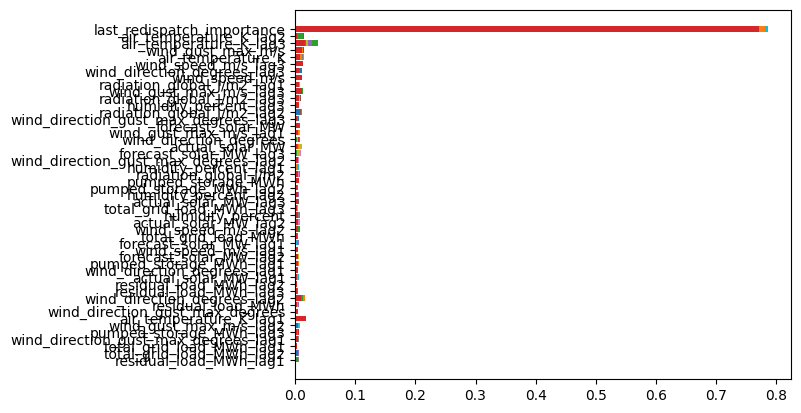

In [33]:
# create model instance
xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=7, eval_metric='logloss', gamma = 5, min_child_weight=2,
                              n_estimators=200, max_depth=3, learning_rate=0.1, objective='binary:logistic', random_state = 13)#, scale_pos_weight=3)
# reg_alpha: L1 regularization (reduce overfitting)
# gamma: minimum loss reduction required to make a further partition on a leaf node of the tree (larger gamma more conservative (reduce overfitting))
# scale_pos_weights: higher weight to the minority class to address class imbalance


# cross-validation
n_splits = 70
test_size = 48 #(12h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

precision_scores = []
f1_scores = []
conf_matrices = []
precision_train_scores = []
f1_train_scores = []
conf_train_matrices = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = X_train.copy()
    X_test = X_test.copy()

    # having at least one instance of redispatch 1 or 0 in test to avoid ill-defined precision/f1 scores
    if y_test.sum() == 0 or y_test.sum() == 1:
        continue

    # add importance of the last redispatch status
    last_redispatch_importance_train, last_redispatch_importance_test = last_redispatch(y_train, X_test)
    X_train['last_redispatch_importance'] = last_redispatch_importance_train
    X_test['last_redispatch_importance'] = last_redispatch_importance_test

    # preprocess data
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    # fit model
    xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

    # make predictions
    y_pred = xgboost_class.predict(X_test_preprocessed)
    y_pred_train = xgboost_class.predict(X_train_scaled)

    #print(y_test.value_counts())
    #print("last redispatch importance: ", X_test['last_redispatch_importance'])

    # evaluate
    precision_scores.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    precision_train_scores.append(precision_score(y_train, y_pred_train))
    f1_train_scores.append(f1_score(y_train, y_pred_train))
    conf_train_matrices.append(confusion_matrix(y_train, y_pred_train))

    sorted_idx = xgboost_class.feature_importances_.argsort()
    plt.barh(X_train.columns[sorted_idx], xgboost_class.feature_importances_[sorted_idx])


# print evaluation results
print("Average Scores:")
print("Precision:", sum(precision_scores) / len(precision_scores))
print("F1-Scores:", sum(f1_scores) / len(f1_scores))
print("Confusion Matrix:", sum(conf_matrices) / len(conf_matrices))
print("Precision (Train):", sum(precision_train_scores) / len(precision_train_scores))
print("F1-Scores (Train):", sum(f1_train_scores) / len(f1_train_scores))
print("Confusion Matrix (Train):", sum(conf_train_matrices) / len(conf_train_matrices))

**Grid Search CV**

• it is doing its own train/test split\
• the last feature importance is calculated for every timestamp. to not get wrong results it is shifted by 48 (12h)


In [42]:
# importance of the last redispatch status for the training data
window_size = 4  #last 60 min
last_redispatch_importance = []
for i in range(len(df)):
    window_start = max(0, i - window_size)
    window_end = i
    importance = df['redispatch'].iloc[window_start:window_end].sum() #also incorporate the level ???
    last_redispatch_importance.append(importance)

df['last_redispatch_importance'] = last_redispatch_importance
df['last_redispatch_importance'] = df['last_redispatch_importance'].shift(48)
df.dropna(inplace = True)

X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [45]:
# preprocess data
X_scaled = preprocessor.fit_transform(X)
X_preprocessed, y_preprocessed = smote.fit_resample(X_scaled, y)

# parameter grid
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5]
}

# timeseries split
test_size = 48
tscv = TimeSeriesSplit(test_size=test_size)

# XGBClassifier and GridSearchCV
xgboost_class = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic', random_state=13)
grid_search = GridSearchCV(estimator=xgboost_class, param_grid=param_grid, cv=tscv, scoring='precision', n_jobs=-1)

# fit
grid_search.fit(X_scaled, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

KeyboardInterrupt: 

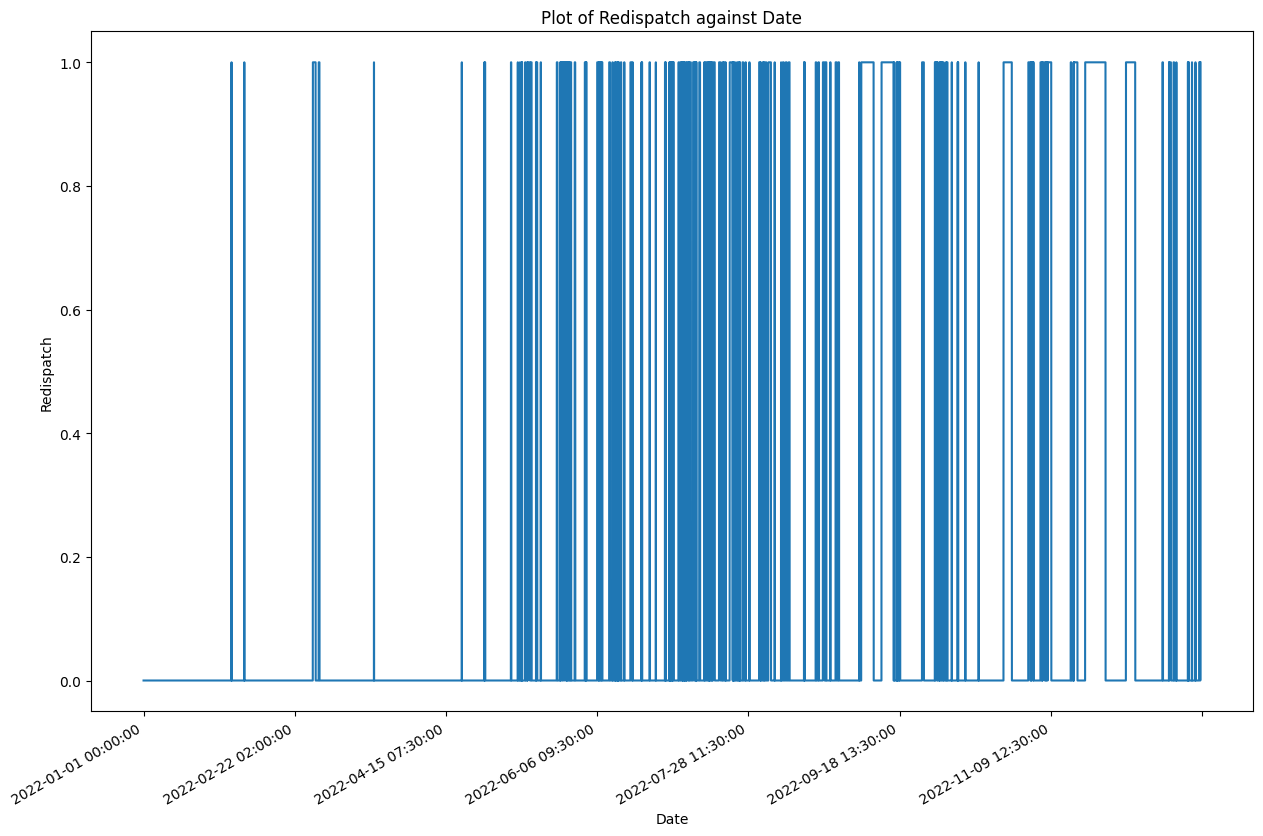

In [8]:
# plot redispatch against the datetime index
start_date = '2022-01-01'
end_date = '2022-12-31'

ax = df.loc[start_date:end_date, 'redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format and limits
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()